In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.legend_handler import HandlerBase
%matplotlib inline

In [4]:
range_N = [200,100,50]
range_R = [1.0,0.9,0.8,0.7,0.6,0.5,0.4, 0.3, 0.2,0.1]
NR = np.zeros((len(range_N),len(range_R)))

In [5]:
# Saving the final loss out of the last 500 values stored.
for indxN, i in enumerate(range_N):
    for indxR, j in enumerate(range_R):
        loss_column = np.loadtxt(r'Data_24july/loss_{}_{}.dat'.format(i,j))
        loss = loss_column[-1]
        NR[indxN][indxR] = loss

In [6]:
# Creates color gradient for legends
class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, ydescent], 
                          width / self.num_stripes, 
                          height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

### Loss Analysis

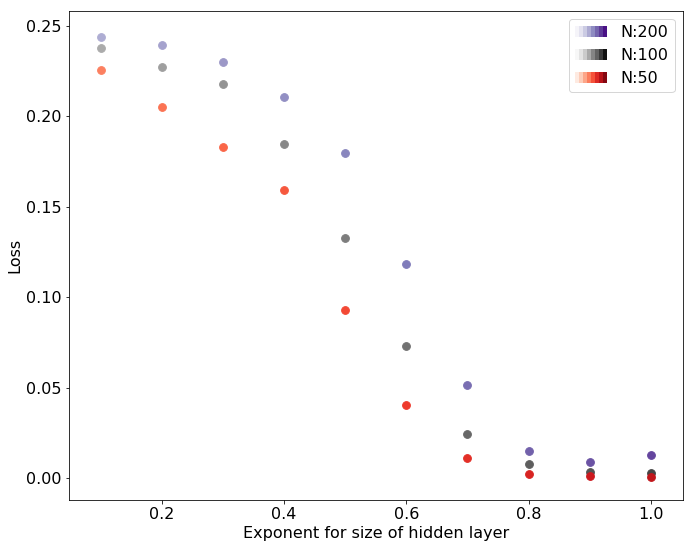

In [17]:
# For a fixed N plotting a range of R for the loss values
greens = plt.get_cmap('Greens')
purples = plt.get_cmap('Purples')
greys = plt.get_cmap('Greys')
reds = plt.get_cmap('Reds')
cmaps = [purples,greys,reds]
cmap_labels=["N:200","N:100","N:50"]
plt.figure(1,figsize=(11,9))
for i in range(len(range_R)):
    plt.scatter(range_R[i],NR[0][i],color=purples(200-10*i), s=60)
    plt.scatter(range_R[i],NR[1][i],color=greys(200-10*i), s=60)
    plt.scatter(range_R[i],NR[2][i],color=reds(200-10*i), s=60)
plt.xlabel('Exponent for size of hidden layer', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.tick_params(labelsize=16)
cmap_handles = [Rectangle((0, 0), 1, 1) for _ in cmaps]
handler_map = dict(zip(cmap_handles, 
                       [HandlerColormap(cm, num_stripes=8) for cm in cmaps]))
plt.legend(handles=cmap_handles, 
           labels=cmap_labels, 
           handler_map=handler_map, 
           fontsize=16)

### Computing the threshold and binarize the output signal

In [18]:
import torch
import difflib

In [19]:
# Activation function
def actfn(x):
    y = x.sigmoid()
    return y

/Users/ghz/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


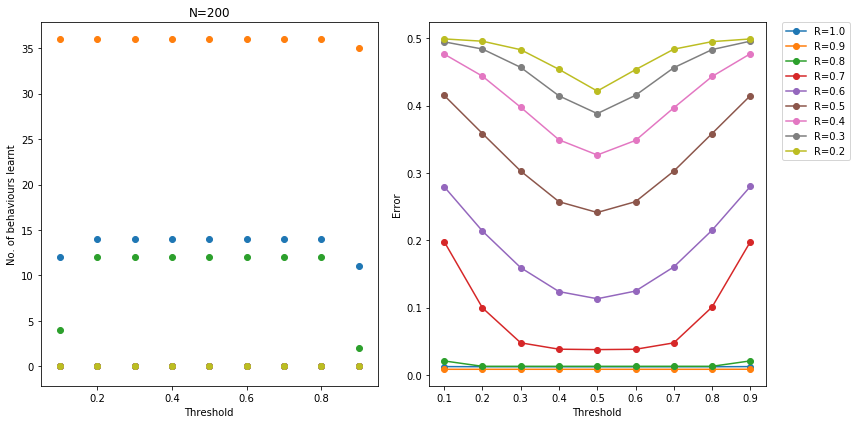

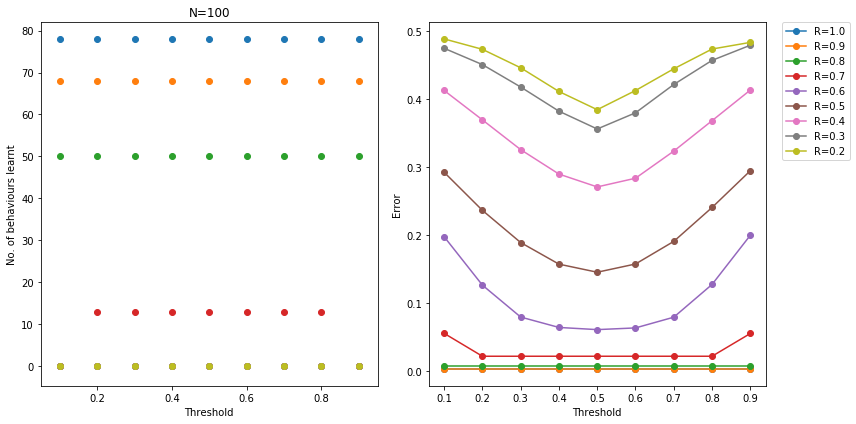

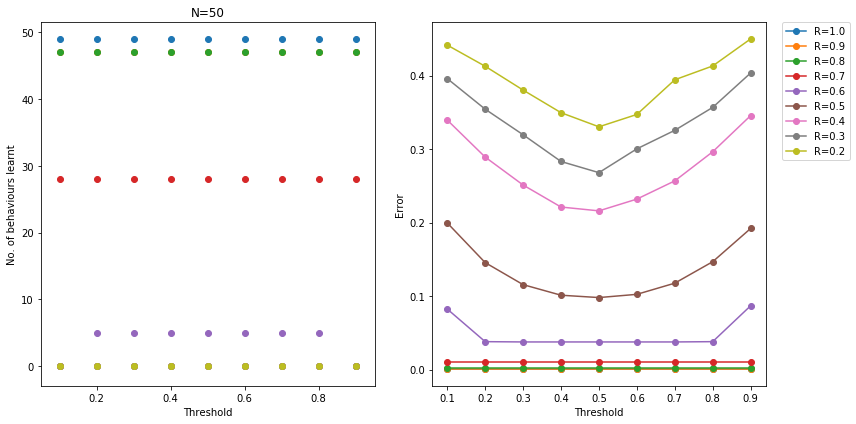

In [21]:
for indxN, N in enumerate(range_N):
    for R in range_R[:-1]:
        
        # Getting data from our database and saved models
        x = torch.tensor(np.genfromtxt(r"x_{}.csv".format(N), delimiter=',')).float()
        y = torch.tensor(np.genfromtxt(r"y_{}.csv".format(N), delimiter=',')).float()
        w1 = torch.tensor(np.loadtxt(r"Data_24july/weights1_{}_{}.dat".format(N,R)), dtype=torch.float32)
        w2 = torch.tensor(np.loadtxt(r"Data_24july/weights2_{}_{}.dat".format(N,R)), dtype=torch.float32)
        b1 = torch.tensor(np.loadtxt(r"Data_24july/bias1_{}_{}.dat".format(N,R)), dtype=torch.float32)
        b2 = torch.tensor(np.loadtxt(r"Data_24july/bias2_{}_{}.dat".format(N,R)), dtype=torch.float32)
        
        # Using the saved weights to generate predict outputs
        y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
        y_pred = y_pred.detach().numpy()
        y_org = y.detach().numpy()
    
        # Computing binary outputs using different thresholds
        thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
        behaviours_learnt = []
        errors_R = []
        for th in thresholds:
            behaviour = 0

            y_pred_binary = np.abs(np.round(y_pred+0.5-th))
            comparison_array = y_org-y_pred_binary
            error = np.sum(np.abs(comparison_array))/N**2
            for j in range(len(y_pred)):
                s = difflib.SequenceMatcher(None, y_org[j],y_pred_binary[j])
                if s.ratio() > 0.99:
                    behaviour += 1
            behaviours_learnt.append(behaviour)
            errors_R.append(error)
        plt.figure(indxN+1,figsize=(12,6))
        plt.subplot(1,2,1)
        plt.scatter(thresholds,behaviours_learnt)
        plt.xlabel('Threshold')
        plt.ylabel('No. of behaviours learnt')
        plt.title('N={}'.format(N))
        plt.tight_layout()
        plt.subplot(1,2,2)
        plt.plot(thresholds,errors_R,'o-',label='R={}'.format(R))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
        plt.xlabel('Threshold')
        plt.ylabel('Error')

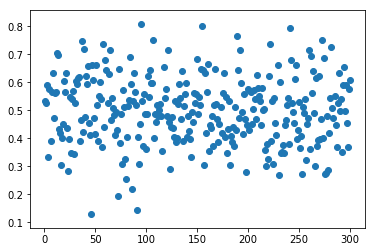

In [31]:
plt.scatter(np.arange(1,301,1),y_pred[2])
# Most entries are centered around 0 and 1 as expected

### Fixing the threshold and varying the amount of sequence similarity

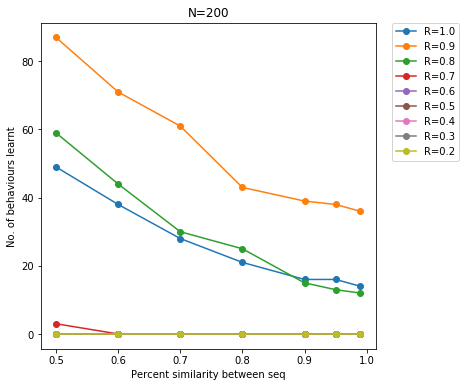

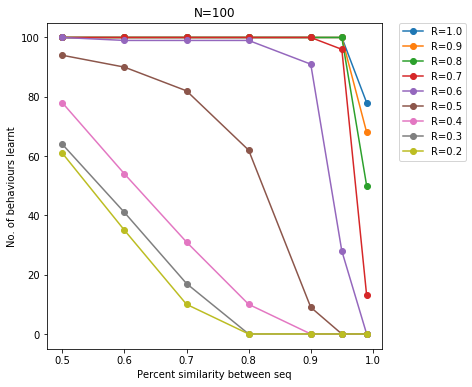

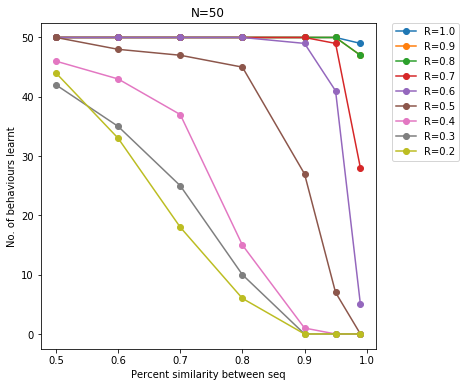

In [22]:
for indxN, N in enumerate(range_N):
    for R in range_R[:-1]:
        
        # Getting data from our database and saved models
        x = torch.tensor(np.genfromtxt(r"x_{}.csv".format(N), delimiter=',')).float()
        y = torch.tensor(np.genfromtxt(r"y_{}.csv".format(N), delimiter=',')).float()
        w1 = torch.tensor(np.loadtxt(r"Data_24july/weights1_{}_{}.dat".format(N,R)), dtype=torch.float32)
        w2 = torch.tensor(np.loadtxt(r"Data_24july/weights2_{}_{}.dat".format(N,R)), dtype=torch.float32)
        b1 = torch.tensor(np.loadtxt(r"Data_24july/bias1_{}_{}.dat".format(N,R)), dtype=torch.float32)
        b2 = torch.tensor(np.loadtxt(r"Data_24july/bias2_{}_{}.dat".format(N,R)), dtype=torch.float32)
        
        # Using the saved weights to generate predict outputs
        y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
        y_pred = y_pred.detach().numpy()
        y_org = y.detach().numpy()
    
        # Computing binary outputs using different thresholds
        threshold = 0.5
        percent_seqmatch = [0.50,0.60,0.70,0.80,0.90,0.95,0.99]
        behaviours_learnt = []
        for per in percent_seqmatch:
            behaviour = 0

            y_pred_binary = np.abs(np.round(y_pred+0.5-threshold))

            for j in range(len(y_pred)):
                s = difflib.SequenceMatcher(None, y_org[j],y_pred_binary[j])
                if s.ratio() > per:
                    behaviour += 1
            behaviours_learnt.append(behaviour)

        plt.figure(indxN+1,figsize=(6,6))
        plt.plot(percent_seqmatch,behaviours_learnt,'o-',label='R={}'.format(R))
        plt.xlabel('Percent similarity between seq')
        plt.ylabel('No. of behaviours learnt')
        plt.title('N={}'.format(N))
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

### Plot of fraction of behaviours learnt as a function of R

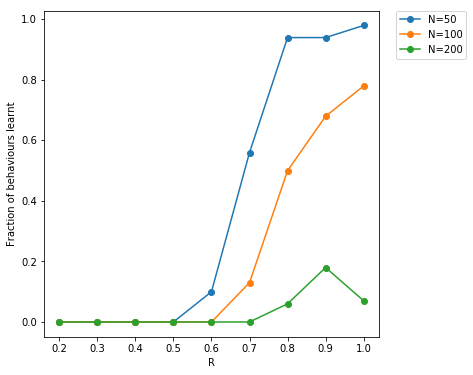

In [44]:
for indxN, N in enumerate([50, 100, 200]):
    behaviours_learnt = []
    for R in range_R[:-1]:
        
        # Getting data from our database and saved models
        x = torch.tensor(np.genfromtxt(r"x_{}.csv".format(N), delimiter=',')).float()
        y = torch.tensor(np.genfromtxt(r"y_{}.csv".format(N), delimiter=',')).float()
        w1 = torch.tensor(np.loadtxt(r"Data_24july/weights1_{}_{}.dat".format(N,R)), dtype=torch.float32)
        w2 = torch.tensor(np.loadtxt(r"Data_24july/weights2_{}_{}.dat".format(N,R)), dtype=torch.float32)
        b1 = torch.tensor(np.loadtxt(r"Data_24july/bias1_{}_{}.dat".format(N,R)), dtype=torch.float32)
        b2 = torch.tensor(np.loadtxt(r"Data_24july/bias2_{}_{}.dat".format(N,R)), dtype=torch.float32)
        
        # Using the saved weights to generate predict outputs
        y_pred = actfn(actfn(x.mm(w1)+b1).mm(w2)+b2)
        y_pred = y_pred.detach().numpy()
        y_org = y.detach().numpy()
    
        # Computing binary outputs using different thresholds
        threshold = 0.5
        percent_seqmatch = [0.99]
        for per in percent_seqmatch:
            behaviour = 0

            y_pred_binary = np.abs(np.round(y_pred+0.5-threshold))

            for j in range(len(y_pred)):
                s = difflib.SequenceMatcher(None, y_org[j],y_pred_binary[j])
                if s.ratio() > per:
                    behaviour += 1
            behaviours_learnt.append(behaviour/N)

    plt.figure(5,figsize=(6,6))
    plt.plot(range_R[:-1],behaviours_learnt,'o-',label='N={}'.format(N))
    plt.xlabel('R')
    plt.ylabel('Fraction of behaviours learnt')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [28]:
beh_N50_mean = behaviours_learnt

In [24]:
%store -r beh_N100_mean
%store -r beh_N100_std

In [45]:
%store -r beh_N200_mean
%store -r beh_N200_std

In [47]:
%store -r beh_N50_mean
%store -r beh_N50_std

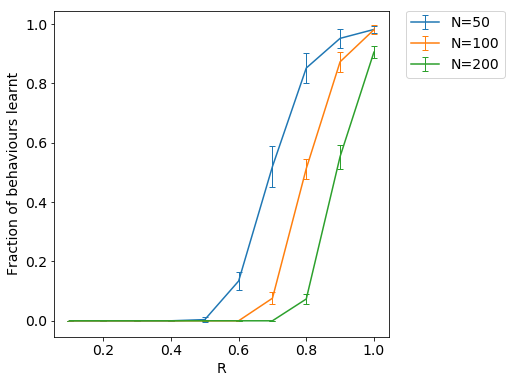

In [50]:
plt.figure(5,figsize=(6,6))
plt.errorbar(range_R, np.array(beh_N50_mean)/50, 
             yerr=np.array(beh_N50_std)/50,
            elinewidth=1, capsize=3,label='N={}'.format(50))
plt.errorbar(range_R, np.array(beh_N100_mean)/100, 
             yerr=np.array(beh_N100_std)/100,
            elinewidth=1, capsize=3,label='N={}'.format(100))
plt.errorbar(range_R, np.array(beh_N200_mean)/200, 
             yerr=np.array(beh_N200_std)/200,
            elinewidth=1, capsize=3,label='N={}'.format(200))
plt.xlabel('R', fontsize=14)
plt.ylabel('Fraction of behaviours learnt', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.tick_params(labelsize=14)
plt.show()